## Adding the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Data Cleaning

In [2]:
# Load the data
file_path = "output.csv"
df = pd.read_csv(file_path)

## Date cleaning

### Dropping rows with null values

In [3]:
# Drop rows with NaN values
df = df.dropna()

### Changing Dates

In [4]:
# # Convert 'Date' column to datetime type
# df['Date'] = pd.to_datetime(df['Date'])

# # Subtract 30 days from each date
# df['Date'] = df['Date'] - pd.Timedelta(days=30)

# # Output the updated DataFrame
# print(df['Date'])

### Taxi and average delay Takeoff Data cleaning 

In [5]:
import re
# Define a function to extract the numeric part from the string
def extract_numeric(text):
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    else:
        return None

# Apply the function to clean the "Taxi Landing" column
df['Taxi Landing'] = df['Taxi Landing'].apply(extract_numeric)
df['Taxi Takeoff'] = df['Taxi Takeoff'].apply(extract_numeric)

### Takeoff Conversion from 12 hours format to 24 hours format

In [6]:
# Define the time-related columns
time_columns = ['Gate Departure Actual', 'Gate Departure Estimated', 'Takeoff Actual', 'Takeoff Estimated', 'Gate Arrival Actual', 'Gate Arrival Estimated', 'Landing Actual', 'Landing Estimated']

# Replace non-time values ('--') with NaN
df[time_columns] = df[time_columns].replace('--', pd.NA)

# Convert time columns to 24-hour format
for column in time_columns:
    # Convert to datetime objects
    df[column] = pd.to_datetime(df[column], errors='coerce')
    # Convert to 24-hour format
    df[column] = df[column].dt.strftime('%H:%M')

# Display the DataFrame after conversion
# print(df[time_columns])
print(df.head())

  Flight Number                   Date  Taxi Takeoff  \
0       SWA2388  WEDNESDAY 27-MAR-2024            14   
1       FFT1895  WEDNESDAY 27-MAR-2024            27   
2       SWA1051  WEDNESDAY 27-MAR-2024            13   
3       NKS2043  WEDNESDAY 27-MAR-2024            14   
4       SWA1979  WEDNESDAY 27-MAR-2024            17   

                 Average Delay Takeoff Gate Departure Actual  \
0         Average Delay: 10-20 minutes                 13:59   
1  Average Delay: Less than 10 minutes                 13:10   
2  Average Delay: Less than 10 minutes                 12:45   
3  Average Delay: Less than 10 minutes                 11:12   
4         Average Delay: 10-20 minutes                 10:53   

  Gate Departure Estimated Takeoff Actual Takeoff Estimated  Taxi Landing  \
0                    14:00          14:13             14:10            14   
1                    13:13          13:37             13:23            27   
2                    12:45          12:58      

/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_33017/3308702546.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column], errors='coerce')
/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_33017/3308702546.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column], errors='coerce')
/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_33017/3308702546.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column], errors='coerce')
/var/folders/_s/m46xfx

## Assigning feature values

In [7]:
# Define features and target
features = ['Takeoff Actual', 'Takeoff Estimated', 'Landing Actual','Landing Estimated']
target = 'Landing Actual'

X = df[features]
y = df[target]
X

,Takeoff Actual,Takeoff Estimated,Landing Actual,Landing Estimated
0,14:13,14:10,15:00,14:57
1,13:37,13:23,14:25,14:10
2,12:58,12:55,13:44,13:43
3,11:26,11:30,12:12,12:18
4,11:10,10:50,11:55,11:38
...,...,...,...,...
263,12:03,10:35,12:54,11:24
264,11:09,10:30,11:56,11:19
266,08:06,08:10,08:53,08:56
267,07:35,07:35,08:22,08:23


## Converting into tensors

In [8]:

# Convert time columns to numerical format (hours and minutes)
for column in ['Takeoff Actual', 'Takeoff Estimated', 'Landing Actual', 'Landing Estimated']:
    df[column] = pd.to_datetime(df[column]).dt.hour * 60 + pd.to_datetime(df[column]).dt.minute

# Define a function to map categories to numerical values
def map_delay_to_numeric(text):
    if 'Less than 10 minutes' in text:
        return 0
    elif '10-20 minutes' in text:
        return 1
    elif '20-40 minutes' in text:
        return 2
    elif '40 minutes - 1 hour' in text:
        return 3
    elif 'More than 1 hour' in text:
        return 4
    else:
        return -1  # Handle unknown cases if any

# Convert all values in 'Average Delay Takeoff' column to strings
df['Average Delay Takeoff'] = df['Average Delay Takeoff'].astype(str)

# Apply the mapping function to convert categories to numerical values
df['Average Delay Takeoff Numeric'] = df['Average Delay Takeoff'].apply(map_delay_to_numeric)

# Define features and target
features = ['Takeoff Actual', 'Takeoff Estimated', 'Landing Estimated', 'Average Delay Takeoff Numeric']
target = 'Landing Actual'

# Extract features and target
X = df[features]
y = df[target]

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

# Split the data into training and testing sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Check the first few rows of the modified DataFrame
print(df[['Average Delay Takeoff', 'Average Delay Takeoff Numeric']].head())

                 Average Delay Takeoff  Average Delay Takeoff Numeric
0         Average Delay: 10-20 minutes                              1
1  Average Delay: Less than 10 minutes                              0
2  Average Delay: Less than 10 minutes                              0
3  Average Delay: Less than 10 minutes                              0
4         Average Delay: 10-20 minutes                              1


/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_33017/1383121638.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column]).dt.hour * 60 + pd.to_datetime(df[column]).dt.minute
/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_33017/1383121638.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] = pd.to_datetime(df[column]).dt.hour * 60 + pd.to_datetime(df[column]).dt.minute
/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_33017/1383121638.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[column] =

## Neural Network Architecture

In [9]:
# Define the correct number of input features
num_input_features = X_train_tensor.shape[1]

# Define neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(num_input_features, 64)  # Input layer
        self.fc2 = nn.Linear(64, 32)                  # Hidden layer
        self.fc3 = nn.Linear(32, 1)                   # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation function to first layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation function to second layer
        x = self.fc3(x)              # Output layer (no activation function)
        return x

# Instantiate the model
model = NeuralNetwork()
# Make predictions on the training data
model.eval()
with torch.no_grad():
    y_pred_train_tensor = model(X_train_tensor)



## Defining loss function and training the model

In [10]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10000
train_losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 820.2932
Epoch [200/10000], Loss: 640.4451
Epoch [300/10000], Loss: 551.9062
Epoch [400/10000], Loss: 380.5000
Epoch [500/10000], Loss: 215.3529
Epoch [600/10000], Loss: 100.5946
Epoch [700/10000], Loss: 48.5519
Epoch [800/10000], Loss: 32.3497
Epoch [900/10000], Loss: 27.0146
Epoch [1000/10000], Loss: 24.0660
Epoch [1100/10000], Loss: 22.0867
Epoch [1200/10000], Loss: 20.7526
Epoch [1300/10000], Loss: 19.8759
Epoch [1400/10000], Loss: 19.3024
Epoch [1500/10000], Loss: 18.9160
Epoch [1600/10000], Loss: 18.6850
Epoch [1700/10000], Loss: 18.5226
Epoch [1800/10000], Loss: 18.4337
Epoch [1900/10000], Loss: 18.3558
Epoch [2000/10000], Loss: 18.2477
Epoch [2100/10000], Loss: 18.1812
Epoch [2200/10000], Loss: 18.1255
Epoch [2300/10000], Loss: 18.0718
Epoch [2400/10000], Loss: 18.0218
Epoch [2500/10000], Loss: 17.9863
Epoch [2600/10000], Loss: 17.9321
Epoch [2700/10000], Loss: 17.8924
Epoch [2800/10000], Loss: 17.8423
Epoch [2900/10000], Loss: 17.7990
Epoch [3000/10000

## Model Evaluation

In [11]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    mse = criterion(y_pred_tensor, y_test_tensor)
    print(f'Mean Squared Error on Test Data: {mse.item():.4f}')

Mean Squared Error on Test Data: 11.9897


## Data Visualisation

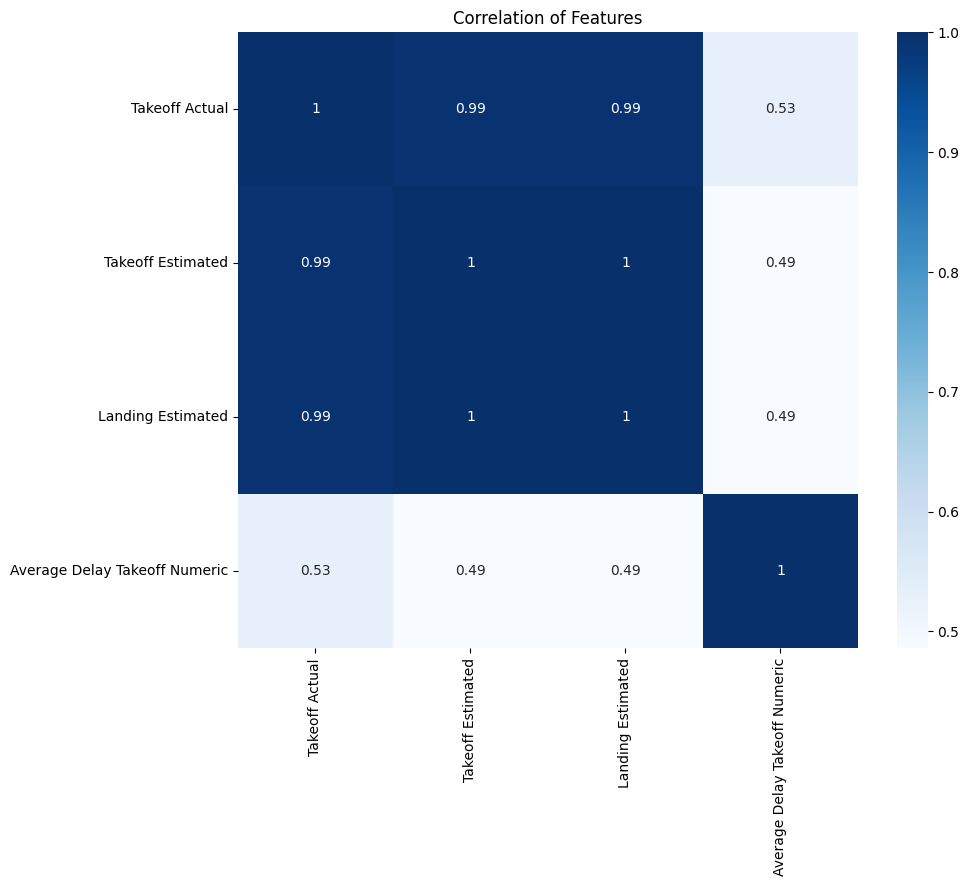

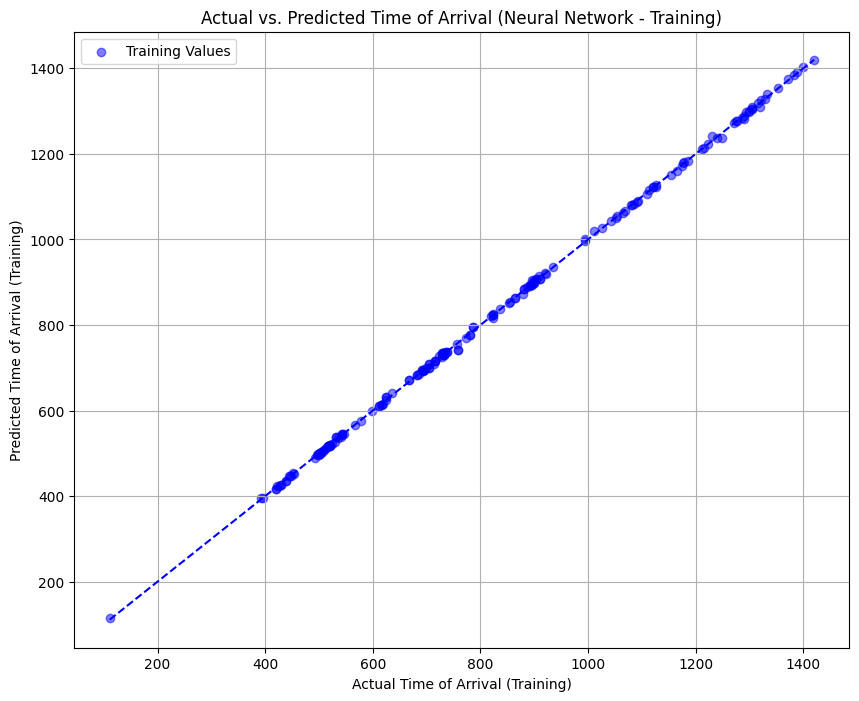

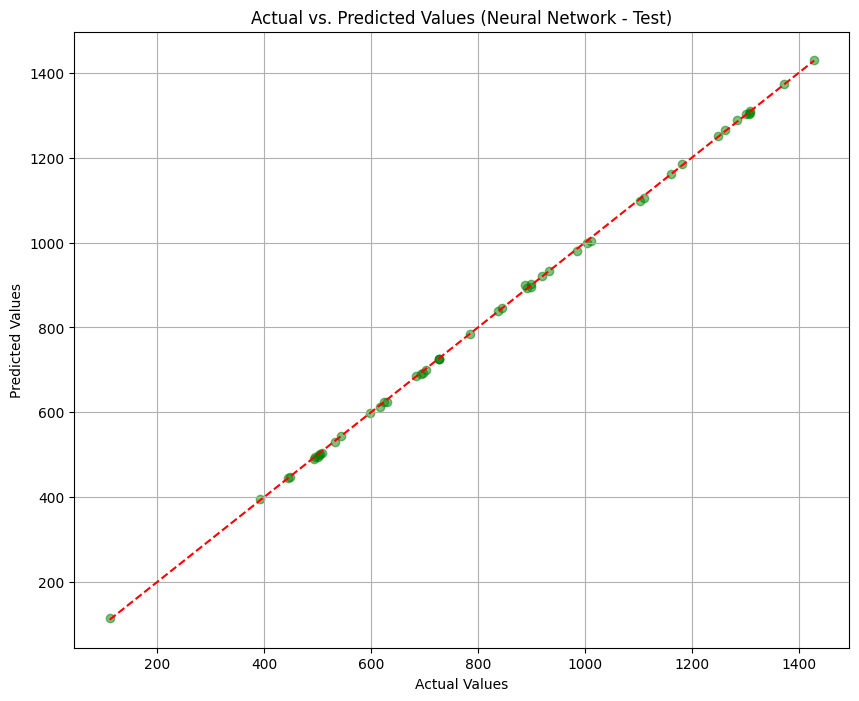

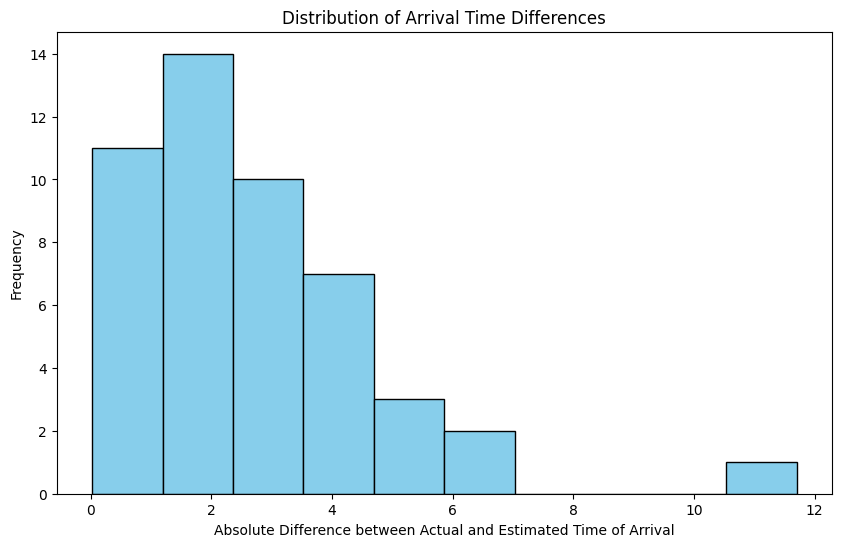

Mean difference: 2.7837436
Maximum difference: 11.704285
Minimum difference: 0.024658203


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap='Blues')
plt.title("Correlation of Features")
plt.show()

# Plot actual vs. predicted values for training data
plt.figure(figsize=(10, 8))
plt.scatter(y_train_tensor, model(X_train_tensor).detach().numpy(), color='blue', alpha=0.5, label='Training Values')
plt.plot([min(y_train_tensor), max(y_train_tensor)], [min(y_train_tensor), max(y_train_tensor)], linestyle='--', color='blue')  # Diagonal line
plt.xlabel("Actual Time of Arrival (Training)")
plt.ylabel("Predicted Time of Arrival (Training)")
plt.title("Actual vs. Predicted Time of Arrival (Neural Network - Training)")
plt.legend()
plt.grid(True)
plt.show()

# Plot actual vs. predicted values for test data
plt.figure(figsize=(10, 8))
plt.scatter(y_test_tensor, y_pred_tensor.numpy(), color='green', alpha=0.5)
plt.plot([min(y_test_tensor), max(y_test_tensor)], [min(y_test_tensor), max(y_test_tensor)], linestyle='--', color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Neural Network - Test)')
plt.grid(True)
plt.show()

# Calculate the absolute difference between actual and estimated time of arrival
arrival_time_difference = torch.abs(y_test_tensor - y_pred_tensor).numpy()

# Visualize the difference
plt.figure(figsize=(10, 6))
plt.hist(arrival_time_difference, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Absolute Difference between Actual and Estimated Time of Arrival')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Time Differences')
plt.show()

# Analyze the difference
mean_difference = arrival_time_difference.mean()
max_difference = arrival_time_difference.max()
min_difference = arrival_time_difference.min()

print("Mean difference:", mean_difference)
print("Maximum difference:", max_difference)
print("Minimum difference:", min_difference)


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convert predicted values to numpy arrays
y_pred_train = model(X_train_tensor).detach().numpy().reshape(-1)
y_pred_test = model(X_test_tensor).detach().numpy().reshape(-1)

# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE) for training and test data
mse_train = mean_squared_error(y_train_tensor, torch.tensor(y_pred_train, dtype=torch.float32))
mae_train = mean_absolute_error(y_train_tensor, torch.tensor(y_pred_train, dtype=torch.float32))
mse_test = mean_squared_error(y_test_tensor, torch.tensor(y_pred_test, dtype=torch.float32))
mae_test = mean_absolute_error(y_test_tensor, torch.tensor(y_pred_test, dtype=torch.float32))

print("Mean Squared Error (MSE) - Train:", mse_train)
print("Mean Absolute Error (MAE) - Train:", mae_train)
print("Mean Squared Error (MSE) - Test:", mse_test)
print("Mean Absolute Error (MAE) - Test:", mae_test)


Mean Squared Error (MSE) - Train: 14.100506
Mean Absolute Error (MAE) - Train: 2.737278
Mean Squared Error (MSE) - Test: 11.989655
Mean Absolute Error (MAE) - Test: 2.7837436


In [14]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_log_error, explained_variance_score

# R² Score (coefficient of determination) = 1 - (SS_res / SS_tot)
# Measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
r2_train = r2_score(y_train_tensor, y_pred_train_tensor)
r2_test = r2_score(y_test_tensor, y_pred_tensor)

# MAPE = (1/n) * Σ(|actual - predicted| / |actual|) * 100%
# Calculates the mean of the absolute percentage errors between the predicted and actual values 
mape_train = mean_absolute_percentage_error(y_train_tensor, y_pred_train_tensor)
mape_test = mean_absolute_percentage_error(y_test_tensor, y_pred_tensor)

# Clip negative values to zero
y_train_tensor_clipped = np.clip(y_train_tensor, 0, None)
y_pred_train_tensor_clipped = np.clip(y_pred_train_tensor, 0, None)
y_test_tensor_clipped = np.clip(y_test_tensor, 0, None)
y_pred_tensor_clipped = np.clip(y_pred_tensor, 0, None)

# Calculate RMSLE with clipped targets
rmsle_train = np.sqrt(mean_squared_log_error(y_train_tensor_clipped, y_pred_train_tensor_clipped))
rmsle_test = np.sqrt(mean_squared_log_error(y_test_tensor_clipped, y_pred_tensor_clipped))

# Calculate Explained Variance Score = 1 - (Var(y_true - y_pred) / Var(y_true))
# Explained Variance Score measures the proportion to which a mathematical model accounts for the variation (dispersion) of a given data set.
explained_variance_train = explained_variance_score(y_train_tensor, y_pred_train_tensor)
explained_variance_test = explained_variance_score(y_test_tensor, y_pred_tensor)

print("R² Score (Train):", r2_train)
print("R² Score (Test):", r2_test)
print("MAPE (Train):", mape_train)
print("MAPE (Test):", mape_test)
print("RMSLE (Train):", rmsle_train)
print("RMSLE (Test):", rmsle_test)
print("Explained Variance Score (Train):", explained_variance_train)
print("Explained Variance Score (Test):", explained_variance_test)


R² Score (Train): -9.524035472842504
R² Score (Test): 0.9998788663896129
MAPE (Train): 1.0767972
MAPE (Test): 0.004131722
RMSLE (Train): 6.6548133
RMSLE (Test): 0.006074277
Explained Variance Score (Train): -0.17172002792358398
Explained Variance Score (Test): 0.9998868107795715


### Ridge Regression to avoid Overfitting

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Initialize Ridge and Lasso regression models
ridge_model = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization strength

# Train Ridge and Lasso models
ridge_model.fit(X_train_tensor, y_train_tensor)

# Predictions
y_pred_ridge_train = ridge_model.predict(X_train_tensor)
y_pred_ridge_test = ridge_model.predict(X_test_tensor)


# Evaluate the models
mse_ridge_train = mean_squared_error(y_train_tensor, y_pred_ridge_train)
mse_ridge_test = mean_squared_error(y_test_tensor, y_pred_ridge_test)


print("Ridge Regression:")
print("Train MSE:", mse_ridge_train)
print("Test MSE:", mse_ridge_test)



Ridge Regression:
Train MSE: 9.39736021800644
Test MSE: 8.73008940060066


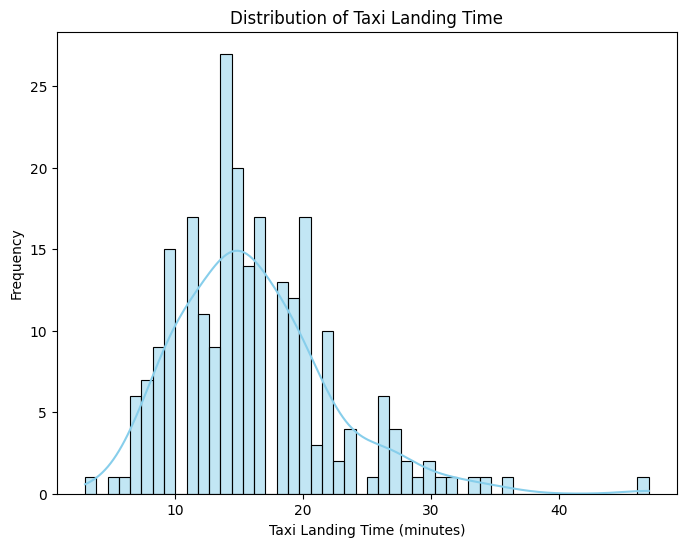

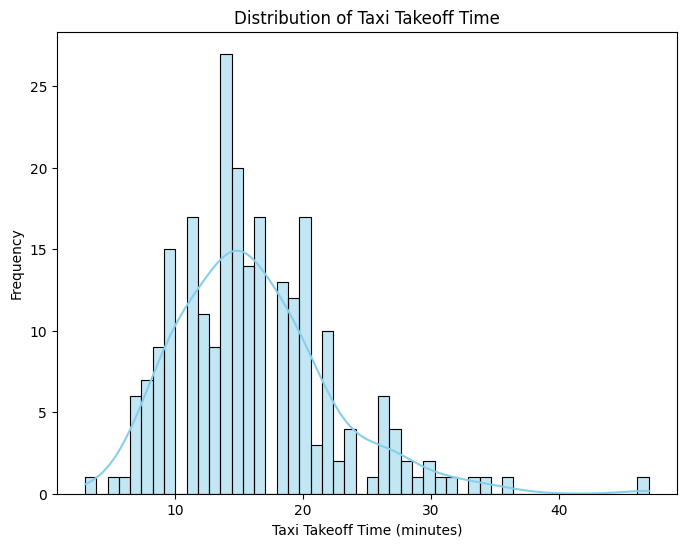

In [16]:

# Histogram: Distribution of taxi landing time with bigger bins
plt.figure(figsize=(8, 6))
sns.histplot(df['Taxi Landing'], bins=50, color='skyblue', edgecolor='black', kde=True)
plt.title('Distribution of Taxi Landing Time')
plt.xlabel('Taxi Landing Time (minutes)')
plt.ylabel('Frequency')

# Histogram: Distribution of taxi takeoff time with bigger bins
plt.figure(figsize=(8, 6))
sns.histplot(df['Taxi Takeoff'], bins=50, color='skyblue', edgecolor='black', kde=True)
plt.title('Distribution of Taxi Takeoff Time')
plt.xlabel('Taxi Takeoff Time (minutes)')
plt.ylabel('Frequency')
plt.show()


/var/folders/_s/m46xfxxs26s25124q82kht4w0000gn/T/ipykernel_33017/1503268127.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Flight Number', y='Average Delay Landing', data=df, palette='viridis')
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  

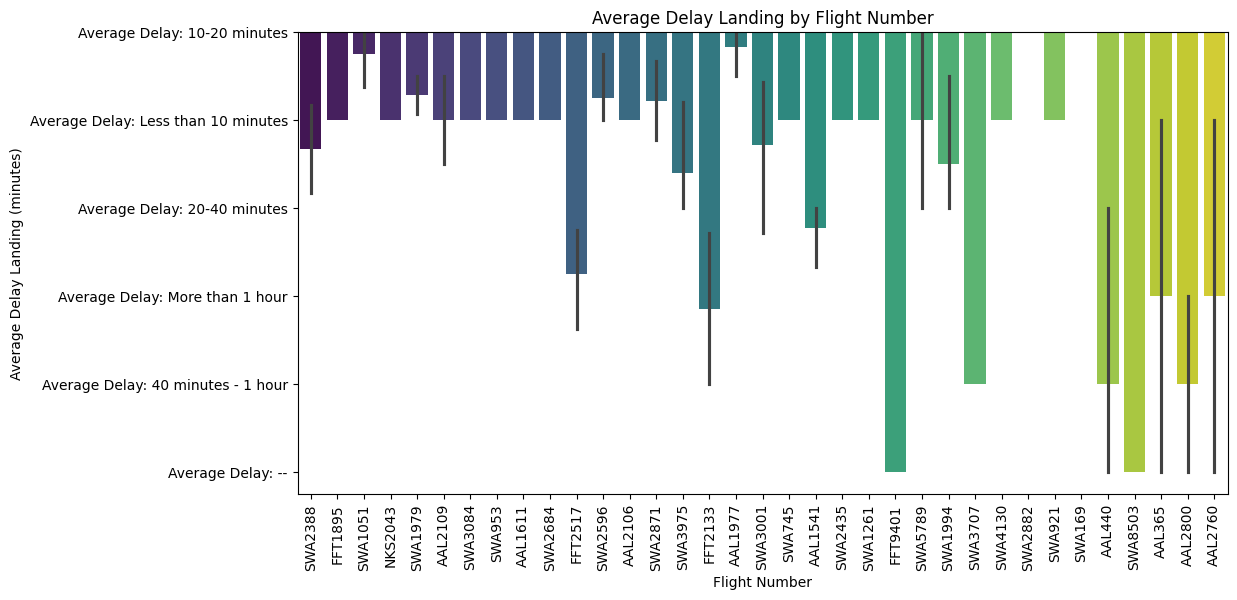

In [17]:
# Bar chart: Average delay landing by flight number
plt.figure(figsize=(12, 6))
sns.barplot(x='Flight Number', y='Average Delay Landing', data=df, palette='viridis')
plt.title('Average Delay Landing by Flight Number')
plt.xlabel('Flight Number')
plt.ylabel('Average Delay Landing (minutes)')
plt.xticks(rotation=90)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


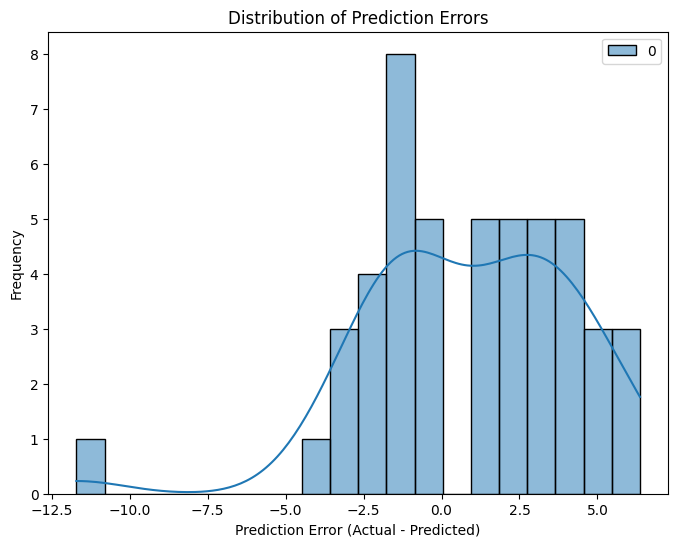

In [18]:
# Assuming y_test_tensor and y_pred_test_tensor are available
# Convert tensor values to numpy arrays
y_test = y_test_tensor.numpy()
y_pred_test = y_pred_tensor.numpy()

# Histogram: Distribution of prediction errors
plt.figure(figsize=(8, 6))
sns.histplot(y_test - y_pred_test, bins=20, color='skyblue', edgecolor='black', kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()


### Importance of features

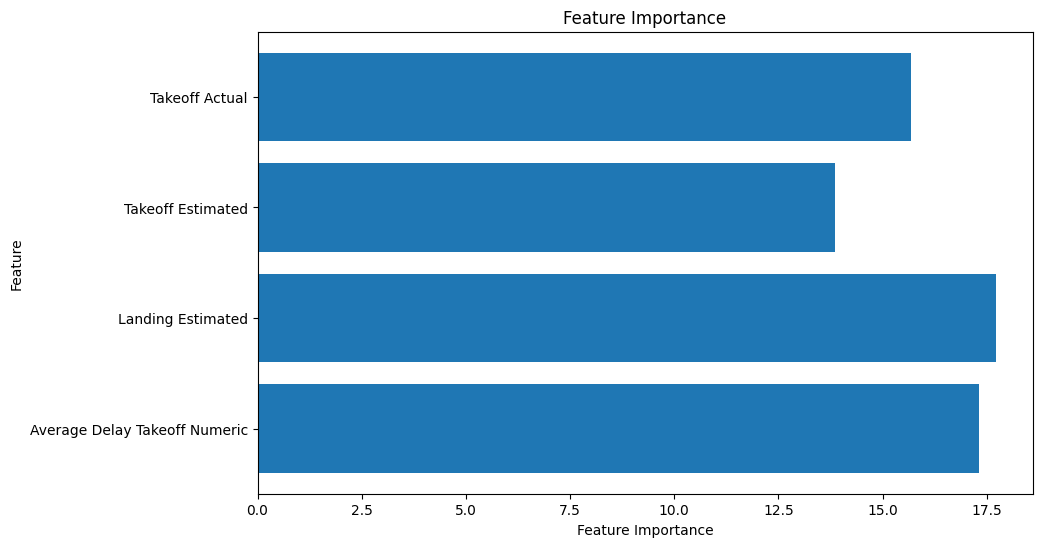

In [19]:

# Get the weights of the input layer
input_layer_weights = model.fc1.weight.detach().numpy()

# Calculate the absolute sum of weights for each feature
feature_importance = np.abs(input_layer_weights).sum(axis=0)  # sum along the columns

# Get the feature names
feature_names = ['Takeoff Actual', 'Takeoff Estimated', 'Landing Estimated', 'Average Delay Takeoff Numeric']

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

### Individual Prediction

In [20]:
import datetime

# Sample input data for testing
sample_input_data = {
    'Takeoff Actual': 8 * 60 + 30,  # Takeoff time  (8:30 AM)
    'Takeoff Estimated': 8 * 60 + 40,  # Estimated takeoff time (8:40 AM)
    'Landing Estimated': 9 * 60 + 50,  # Estimated landing time (9:50 AM)
    'Average Delay Takeoff Numeric': 1  # Numeric representation of average delay
}

# Function to predict actual time of arrival using sample input data
def predict_actual_time_of_arrival(model, sample_input_data):
    new_data = []
    for feature in features:
        if feature in sample_input_data:
            if feature == 'Landing Actual' and sample_input_data[feature] is None:
                new_data.append(0)  # You can replace this with any default value
            else:
                new_data.append(sample_input_data[feature])

    # Convert new flight data to tensor
    new_data_tensor = torch.tensor([new_data], dtype=torch.float32)

    # Make prediction
    predicted_arrival_time_tensor = model(new_data_tensor)
    
    # Convert tensor to float
    predicted_arrival_time = predicted_arrival_time_tensor.item()

    # Print the predicted arrival time
    print(f"Predicted Actual Time of Arrival: {predicted_arrival_time:.2f} minutes")

    return predicted_arrival_time

# Use the function to predict actual time of arrival for a new flight with sample input data
predicted_arrival_time = predict_actual_time_of_arrival(model, sample_input_data)

# Function to convert minutes to time of day
def minutes_to_time(minutes):
    hours = minutes // 60
    minutes = minutes % 60
    return datetime.time(hour=int(hours), minute=int(minutes))

# Convert the predicted arrival time from minutes to time of day
predicted_arrival_time_hours = minutes_to_time(predicted_arrival_time)

# Print the predicted arrival time
print(f"Predicted Actual Time of Arrival: {predicted_arrival_time_hours}")


Predicted Actual Time of Arrival: 569.90 minutes
Predicted Actual Time of Arrival: 09:29:00
